Use decision trees to prepare a model on fraud data treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split

In [3]:
fraud=pd.read_csv('Fraud_check (1).csv')
fraud

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


# Exploratory Data Analysis

In [4]:
fraud.info() # null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [5]:
fraud.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


In [6]:
fraud.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [7]:
fraud.duplicated().sum() # no duplicate values

0

In [8]:
fraud1=fraud.drop(['City.Population'],axis=1)
fraud1


,Undergrad,Marital.Status,Taxable.Income,Work.Experience,Urban
0,NO,Single,68833,10,YES
1,YES,Divorced,33700,18,YES
2,NO,Married,36925,30,YES
3,YES,Single,50190,15,YES
4,NO,Married,81002,28,NO
...,...,...,...,...,...
595,YES,Divorced,76340,7,YES
596,YES,Divorced,69967,2,YES
597,NO,Divorced,47334,0,YES
598,YES,Married,98592,17,NO


In [9]:
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
fraud1['Undergrad']=le.fit_transform(fraud1['Undergrad'])
fraud1['Urban']=le.fit_transform(fraud1['Urban'])
fraud1

,Undergrad,Marital.Status,Taxable.Income,Work.Experience,Urban
0,0,Single,68833,10,1
1,1,Divorced,33700,18,1
2,0,Married,36925,30,1
3,1,Single,50190,15,1
4,0,Married,81002,28,0
...,...,...,...,...,...
595,1,Divorced,76340,7,1
596,1,Divorced,69967,2,1
597,0,Divorced,47334,0,1
598,1,Married,98592,17,0


In [10]:
#One Hot Encoding
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit_transform(fraud1[['Marital.Status']]).toarray()

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [11]:
encoded_cols = enc.fit_transform(fraud1[['Marital.Status']]).toarray()
encoded_cols = pd.DataFrame(encoded_cols, columns=enc.get_feature_names_out(['Marital.Status']))
data = pd.concat([fraud1, encoded_cols], axis=1)
data

,Undergrad,Marital.Status,Taxable.Income,Work.Experience,Urban,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single
0,0,Single,68833,10,1,0.0,0.0,1.0
1,1,Divorced,33700,18,1,1.0,0.0,0.0
2,0,Married,36925,30,1,0.0,1.0,0.0
3,1,Single,50190,15,1,0.0,0.0,1.0
4,0,Married,81002,28,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
595,1,Divorced,76340,7,1,1.0,0.0,0.0
596,1,Divorced,69967,2,1,1.0,0.0,0.0
597,0,Divorced,47334,0,1,1.0,0.0,0.0
598,1,Married,98592,17,0,0.0,1.0,0.0


In [12]:
data1=data.drop(['Marital.Status'],axis=1)
data1

,Undergrad,Taxable.Income,Work.Experience,Urban,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single
0,0,68833,10,1,0.0,0.0,1.0
1,1,33700,18,1,1.0,0.0,0.0
2,0,36925,30,1,0.0,1.0,0.0
3,1,50190,15,1,0.0,0.0,1.0
4,0,81002,28,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
595,1,76340,7,1,1.0,0.0,0.0
596,1,69967,2,1,1.0,0.0,0.0
597,0,47334,0,1,1.0,0.0,0.0
598,1,98592,17,0,0.0,1.0,0.0


Converting Taxable.Income data into 2 categories "Risky" and others are "Good" by binning sales columns


In [13]:
 max(data1['Taxable.Income'])

99619

In [14]:
data1["Fraud_check"] = pd.cut(data["Taxable.Income"], bins=[0, 30000,max(data['Taxable.Income'])], labels=["Risky", "Good"])
data1["Fraud_check"] 

0      Good
1      Good
2      Good
3      Good
4      Good
       ... 
595    Good
596    Good
597    Good
598    Good
599    Good
Name: Fraud_check, Length: 600, dtype: category
Categories (2, object): ['Risky' < 'Good']

In [15]:
data1

,Undergrad,Taxable.Income,Work.Experience,Urban,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Fraud_check
0,0,68833,10,1,0.0,0.0,1.0,Good
1,1,33700,18,1,1.0,0.0,0.0,Good
2,0,36925,30,1,0.0,1.0,0.0,Good
3,1,50190,15,1,0.0,0.0,1.0,Good
4,0,81002,28,0,0.0,1.0,0.0,Good
...,...,...,...,...,...,...,...,...
595,1,76340,7,1,1.0,0.0,0.0,Good
596,1,69967,2,1,1.0,0.0,0.0,Good
597,0,47334,0,1,1.0,0.0,0.0,Good
598,1,98592,17,0,0.0,1.0,0.0,Good


In [16]:
data2=data1.drop(['Taxable.Income'],axis=1)
data2


,Undergrad,Work.Experience,Urban,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single,Fraud_check
0,0,10,1,0.0,0.0,1.0,Good
1,1,18,1,1.0,0.0,0.0,Good
2,0,30,1,0.0,1.0,0.0,Good
3,1,15,1,0.0,0.0,1.0,Good
4,0,28,0,0.0,1.0,0.0,Good
...,...,...,...,...,...,...,...
595,1,7,1,1.0,0.0,0.0,Good
596,1,2,1,1.0,0.0,0.0,Good
597,0,0,1,1.0,0.0,0.0,Good
598,1,17,0,0.0,1.0,0.0,Good


In [17]:
Fraud_dataa=data2

In [18]:
Fraud_dataa['Fraud_check'].value_counts() #the data is not balanced

Good     476
Risky    124
Name: Fraud_check, dtype: int64

In [19]:
x=Fraud_dataa.iloc[:,0:-1]
y=Fraud_dataa.iloc[:,-1]

In [20]:
x

,Undergrad,Work.Experience,Urban,Marital.Status_Divorced,Marital.Status_Married,Marital.Status_Single
0,0,10,1,0.0,0.0,1.0
1,1,18,1,1.0,0.0,0.0
2,0,30,1,0.0,1.0,0.0
3,1,15,1,0.0,0.0,1.0
4,0,28,0,0.0,1.0,0.0
...,...,...,...,...,...,...
595,1,7,1,1.0,0.0,0.0
596,1,2,1,1.0,0.0,0.0
597,0,0,1,1.0,0.0,0.0
598,1,17,0,0.0,1.0,0.0


In [21]:
y

0      Good
1      Good
2      Good
3      Good
4      Good
       ... 
595    Good
596    Good
597    Good
598    Good
599    Good
Name: Fraud_check, Length: 600, dtype: category
Categories (2, object): ['Risky' < 'Good']

# Visualizing the data

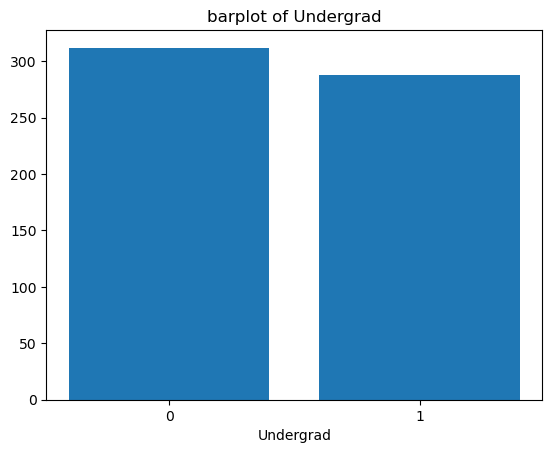

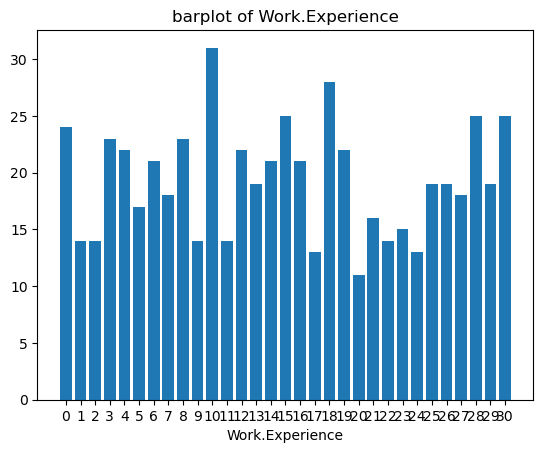

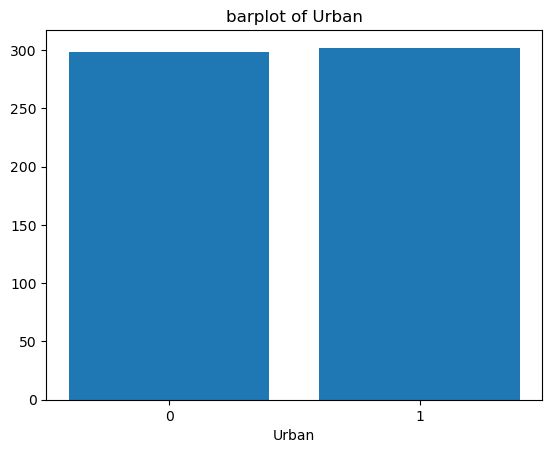

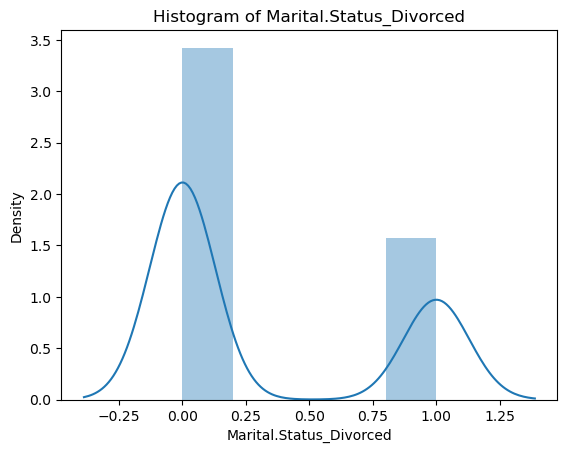

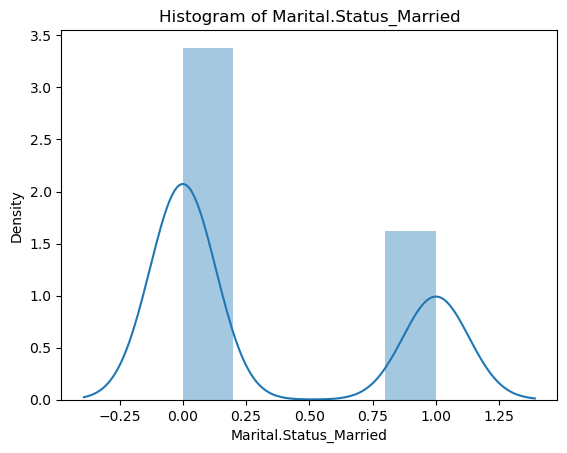

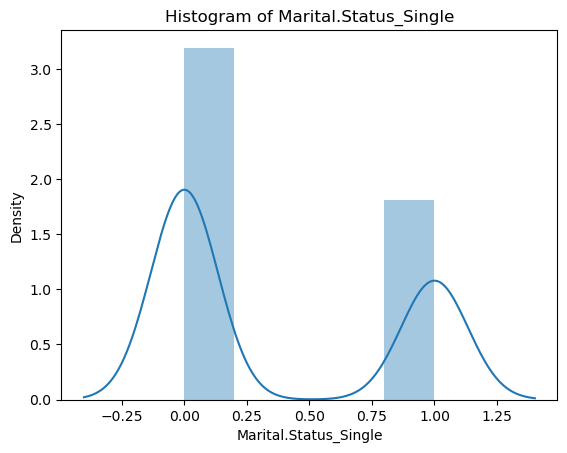

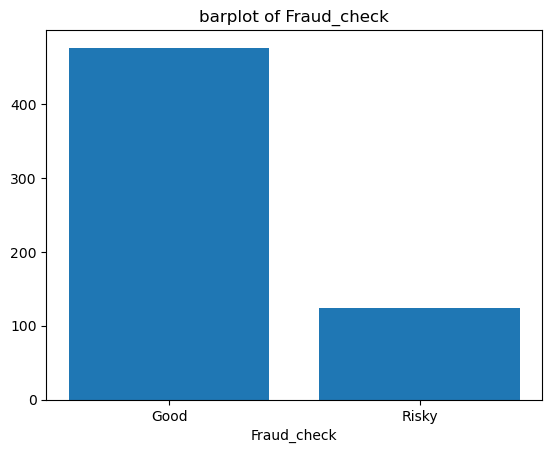

In [44]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
# Loop through each column in the DataFrame
for column in Fraud_dataa.columns:
    if Fraud_dataa[column].dtype ==  'float64':
        # Plot the bar plot
        sns.distplot(Fraud_dataa[column])
        # Add labels and a title to the plot
        plt.xlabel(column)
        plt.title('Histogram of ' + column)
        plt.show()
    else:
        plt.bar(Fraud_dataa[column].unique(),Fraud_dataa[column].value_counts())
        # Add labels and a title to the plot
        plt.xlabel(column)
        plt.xticks(Fraud_dataa[column].unique())
        plt.title('barplot of ' + column)
        # Show the plot
        plt.show()

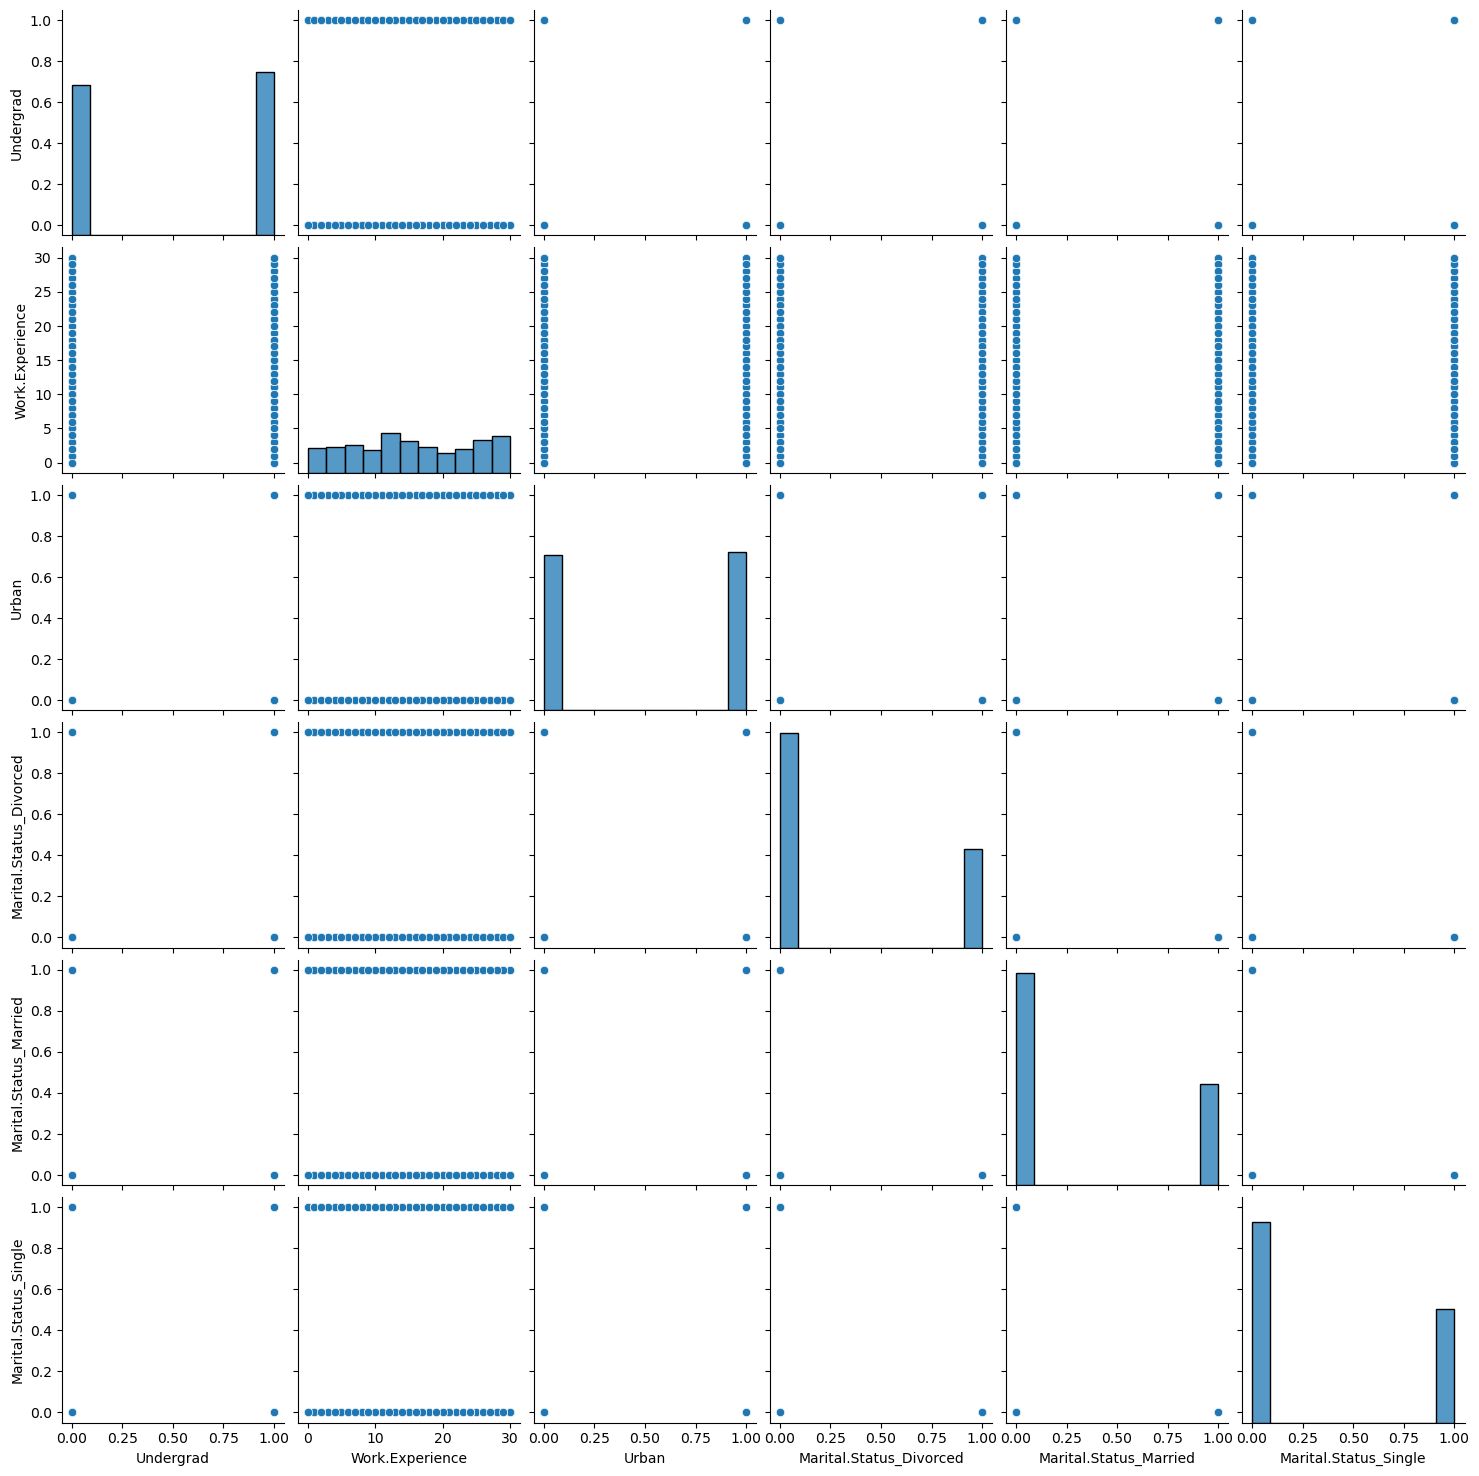

In [23]:
import seaborn as sns
sns.pairplot(Fraud_dataa)

# Splitting the data into train and test

In [24]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=15)
num_trees=100
model1=BaggingClassifier(max_samples=0.8,n_estimators=num_trees,random_state=8)
results=cross_val_score(model1,x_train,y_train,cv=10)
print(results.mean())

0.6977777777777778


# Bagged decision tree for classification

In [25]:
 from sklearn.metrics import classification_report as CR

In [26]:
#We are checking classification report because the data is imbalanced.
model2=BaggingClassifier(max_samples=0.8,n_estimators=num_trees,random_state=8)
model2.fit(x_train,y_train)
pred=model2.predict(x_test)
print(CR(y_test,pred))

              precision    recall  f1-score   support

        Good       0.82      0.90      0.86       123
       Risky       0.20      0.11      0.14        27

    accuracy                           0.76       150
   macro avg       0.51      0.51      0.50       150
weighted avg       0.71      0.76      0.73       150



# Random Forest Classification

In [27]:
from sklearn.ensemble import RandomForestClassifier as RF

In [28]:
from sklearn.ensemble import RandomForestClassifier
model=RF()
paramters={
    
    "n_estimators":[10,20,30,40,100],
    "max_features":[2,4,6]
}

In [35]:
from sklearn.model_selection import GridSearchCV
grcv=GridSearchCV(model,paramters,cv=10)

In [36]:
grcv.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_features': [2, 4, 6],
                         'n_estimators': [10, 20, 30, 40, 100]})

In [37]:
grcv.best_score_

0.7000000000000001

In [38]:
grcv.best_params_

{'max_features': 4, 'n_estimators': 100}

In [39]:
num_trees=100
max_features=4
model3=RF(n_estimators=num_trees,max_samples=0.8,max_features=max_features,random_state=15)
results=cross_val_score(model3,x_train,y_train,cv=10)
print(results.mean())
model3.fit(x_train,y_train)
pred1=model3.predict(x_test)
print(CR(y_test,pred1))

0.7022222222222222
              precision    recall  f1-score   support

        Good       0.82      0.86      0.84       123
       Risky       0.15      0.11      0.13        27

    accuracy                           0.73       150
   macro avg       0.48      0.49      0.48       150
weighted avg       0.70      0.73      0.71       150



# Adaboost classification or Boosting

In [41]:
from sklearn.ensemble import AdaBoostClassifier as AD

In [42]:
num_trees=10
model4=AD(n_estimators=num_trees,learning_rate=0.8,random_state=15)
results=cross_val_score(model4,x_train,y_train,cv=10)
print(results.mean())
model4.fit(x_train,y_train)
pred2=model4.predict(x_test)
print(CR(y_test,pred2))

0.7844444444444445
              precision    recall  f1-score   support

        Good       0.82      1.00      0.90       123
       Risky       0.00      0.00      0.00        27

    accuracy                           0.82       150
   macro avg       0.41      0.50      0.45       150
weighted avg       0.67      0.82      0.74       150

